In [1]:
import sys
sys.path.insert(0, r'../..')

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import imageio
from tqdm import tqdm_notebook as tqdm

In [3]:
from lib.video import *

In [4]:
TEST_VIDEO = '../../data/test/resized_645001_5.mp4'

In [40]:
SHAPE_VIDEO = next(get_reader(TEST_VIDEO)).shape
FRAME_RATE = 4
SKIP = 0
SIZE = None
GOOD_COLORS = [0, 1, 2]

In [41]:
def calc_green_pixels(frame):
    frame = frame.astype('float')
    return frame[:, :, 1] * 1 > frame[:, :, 0] + frame[:, :, 2]


def calc_green_counts(path):
    total = 0
    mask = np.zeros(SHAPE_VIDEO[:2])
    for frame in tqdm(get_reader(path, FRAME_RATE, skip=SKIP, size=SIZE),
                      total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
        mask += calc_green_pixels(frame)
        total += 1
    return mask / total

In [42]:
green_counts = calc_green_counts(TEST_VIDEO)

A Jupyter Widget

In [43]:
def extract_green_mask(green_counts, threshold=0.24):
    return green_counts < threshold

In [44]:
def clean_borders(mask, size=4):
    mask = mask.copy()
    h, w = mask.shape[:2]
    borders = np.ones_like(mask)
    borders[size:-size, size:-size] = 0
    mask[borders] = 0
    return mask

In [45]:
def search_best_green_threshold(green_counts, proportion=0.01):
    last = 0
    for gt in np.linspace(0, 1, 15):
        mask = extract_green_mask(green_counts, gt)
        if mask.mean() > proportion:
            return gt

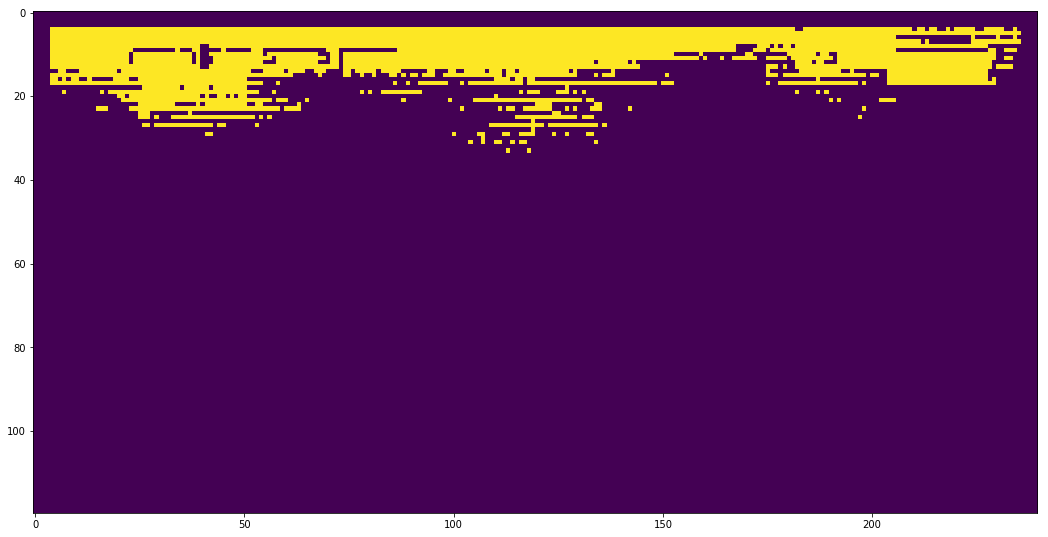

In [48]:
green_threshold = search_best_green_threshold(green_counts, proportion=0.02)
ui_mask = extract_green_mask(green_counts, green_threshold)
ui_mask = clean_borders(ui_mask)
show_img(ui_mask)

In [30]:
def transfrom_color(color, k=8):
    return tuple(color // k * k)

In [31]:
from collections import defaultdict, Counter

good_colors = defaultdict(Counter)
total = 0
for frame in tqdm(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE),
                  total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
    for i in range(ui_mask.shape[0]):
        for j in range(ui_mask.shape[1]):
            if ui_mask[i, j]:
                good_colors[i, j][transfrom_color(frame[i, j])] += 1
    total += 1

A Jupyter Widget

In [32]:
def search_best_static_thershold(n):
    return 60 * 90 / (n * FRAME_RATE) + 0.1

0.8580011229646266


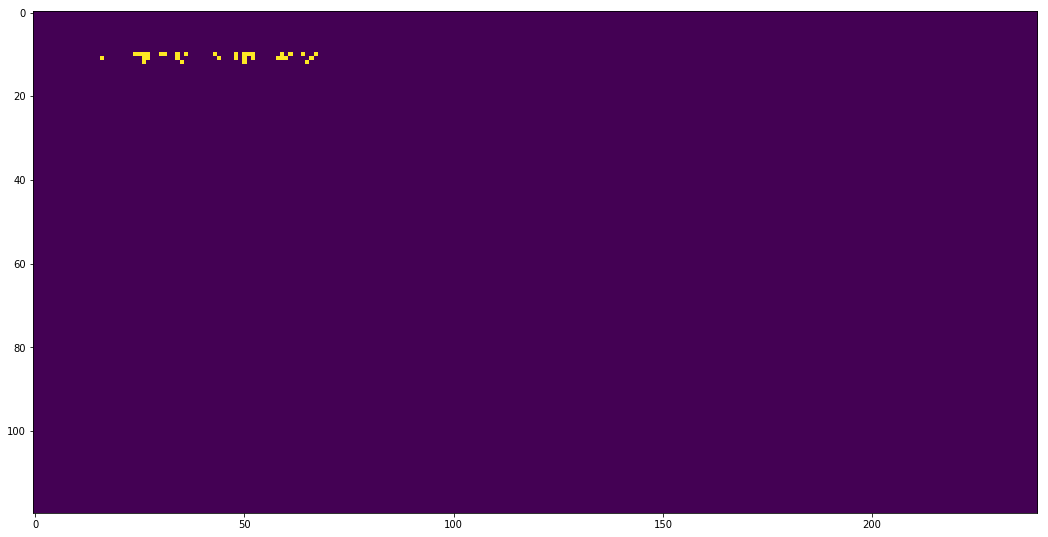

In [33]:
N_TOP_COLORS = 100
static_thershold = search_best_static_thershold(get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=None))
print(static_thershold)
nmask = np.zeros_like(ui_mask)
for pixel, counter in good_colors.items():
    mc = counter.most_common(N_TOP_COLORS)
    prob = sum(v for k, v in mc) / sum(v for k, v in counter.items())
    if prob > static_thershold and prob < 0.9:
        nmask[pixel] = 1
show_img(nmask)

In [228]:
rgood_colors = {
    pixel: {k for k, v in counter.most_common(N_TOP_COLORS)} 
    for pixel, counter in good_colors.items()
    if nmask[pixel]
}

In [229]:
dx = [0, 0, 1, -1, -1, 1, 1, -1]
dy = [1, -1, 0, 0, -1, 1, -1, 1]

In [230]:
def sim_ui(frame, good_colors, mask):
    simularity = np.zeros_like(mask, dtype='uint8')
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                if transfrom_color(frame[i, j]) in good_colors[i, j]:
                    for k in range(len(dx)):
                        p = i+dx[k], j+dy[k]
                        if mask[p]:
                            simularity[p] = 2
                else:
                    if simularity[i, j] == 0:
                        simularity[i, j] = 1
    sim = (simularity == 2).sum() / mask.sum()
    return sim

In [231]:
sims = []
for frame in tqdm(get_reader(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE),
                  total=get_total_len(TEST_VIDEO, FRAME_RATE, skip=SKIP, size=SIZE)):
    sim = sim_ui(frame, rgood_colors, nmask)
    sims.append(sim)
    if sim > 0.9 and False:
        print(sim)
        show_img(frame, 0.4)
        plt.show()

A Jupyter Widget

In [232]:
np.percentile(sims, 30)

0.87234042553191493

In [242]:
def ui_filter(ui_prob, l, r):
    data = np.array(ui_prob)
    data[data >r] = 1
    data[data <l] = -1
    data[np.abs(data) < 1] = 0
    return data

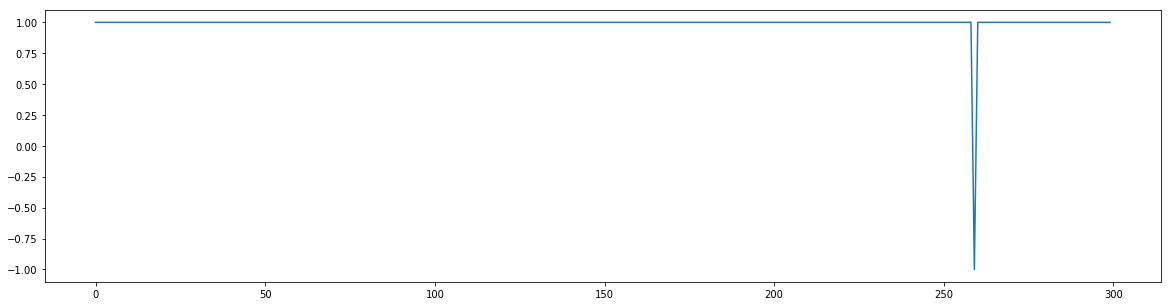

In [248]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(ui_filter(sims, 0.1, 0.1))

In [ ]:
def find_start(sims, frame_rate):
    l =  45 * 60 // frame_rate
    n = len(sims)
    pref = np.cumsum(np.array(sims) > 0.85)
    mx = -1
    best_l1, best_l2 = -1, -1
    for l1 in range(n - l):
        for l2 in range(l1 + l, n - l):
            s1, s2 = pref[l1 + l] - pref[l1], pref[l2 + l] - pref[l2]
            s = s1 + s2
            if mx < s1 + s2:
                mx = s1 + s2
                best_l1, best_l2 = l1, l2
    return best_l1 * frame_rate, best_l2 * frame_rate

In [ ]:
find_start(sims, 4)